# DBSCAN for outliers detection

This notebook attempts to use DBSCAN for outlier detection and automate auto-tuning of the parameters. 

It works through two possible scenarios:
- Estimate eps based on the knee method and a user-provided minimum of samples, which a best estimate for most timeseries as an option
- Use the silhouette method to heuristically determine all parameters (preferred).

The knee method returns too many false positive. Although faster, it is not the method of choice. 

In [1]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import OPTICS
import pyleoclim as pyleo
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from kneed import DataGenerator, KneeLocator #Note that this package is currently not available for Pyleoclim (but it is well maintained and has a large user base)
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.colors as mcolors
import random

## Generate a timeseries with outliers 

For testing puposes, let's generate a "perfect" signal with periodicities of 20 and 80 and add outliers within 2-3 standard deviations of the mean signal:

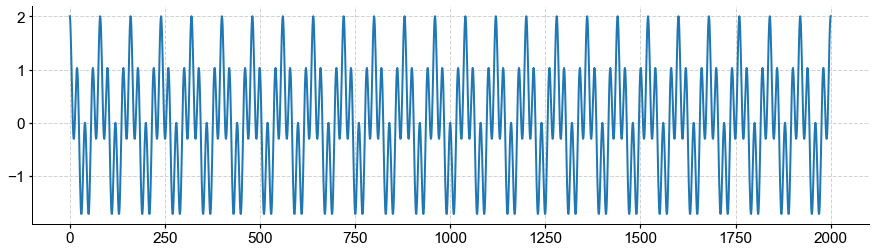

In [16]:
# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)
    
fig=plt.figure(figsize=(15,4))
plt.plot(time,signal)

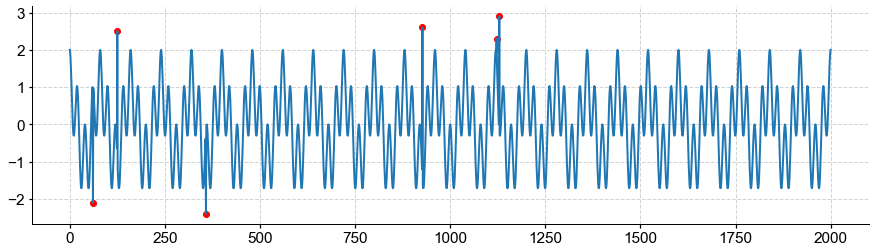

In [17]:
# Add outliers

outliers_start = np.mean(signal)+2*np.std(signal)
outliers_end = np.mean(signal)+3*np.std(signal)
vals = np.arange(outliers_start,outliers_end,0.1)
outlier_values=np.concatenate((vals,-vals))

#set the outliers
nbr_out=6 #just add 6 random outliers
index = np.random.randint(0,len(signal),nbr_out) #Index on the time series
out_index = np.random.randint(0,len(outlier_values),nbr_out)
val_out=outlier_values[out_index]
time_out = time[index]

signal_out = np.copy(signal)
for idx,item in enumerate(index):
    signal_out[item] = val_out[idx]

fig=plt.figure(figsize=(15,4))
plt.plot(time,signal_out)
plt.scatter(time_out,outlier_values[out_index],color='r')

Let's look at the indices where we added outliers:

In [62]:
np.sort(index)

array([ 992, 1354, 1455, 1610, 1631, 1752])

## Using DBSCAN: Simple Example

We plan to use the DBSCAN algorithm for outliers detection. The behavior of the model is affected by three parameters:

- eps: Two points are considered neighbors if the distance between the two points is below the threshold epsilon.
- min_samples: The minimum number of neighbors a given point should have in order to be classified as a core point. It’s important to note that the point itself is included in the minimum number of samples. If the value of this parameter is set to 8, then there must be at least 8 points to form a cluster.
- metric: The metric to use when calculating distance between instances in a feature array (i.e. euclidean distance). Eculidean should work for timeseries applications.

Taken from: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc


First step: generate nicely defined clusters

### Knee method

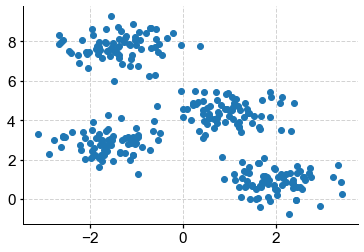

In [4]:
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1])

To determine a suitable value for eps, follow the following recipe: https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

In [5]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

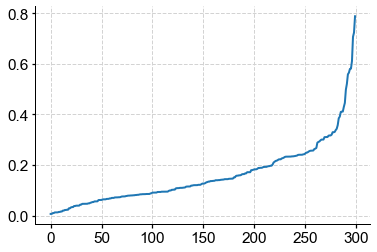

In [6]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Let's do this by eye for now and use eps=0.3

In [7]:
m = DBSCAN(eps=0.3, min_samples=5)
m.fit(X)

DBSCAN(eps=0.3)

The `labels_` property contains the list of clusters and their respective points.

In [8]:
clusters = m.labels_
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

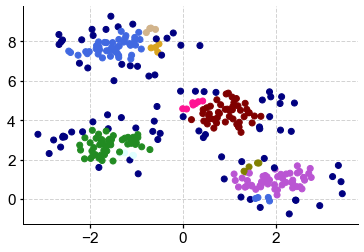

In [9]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.scatter(X[:,0], X[:,1], c=vectorizer(clusters))

To get centroid coordinates:

In [14]:
points_of_cluster_0 = X[m.labels_==0,:]
centroid_of_cluster_0 = np.mean(points_of_cluster_0, axis=0) 
print(centroid_of_cluster_0)

[-1.52013661  7.70327634]


### Silhouette Score method

Let's look at the impact of eps and min_samples:

- Run values of eps between 0.05 and 0.8 based on the knee plot above
- Run values of min_samples from 5 to 30

Let's evaluate performance on silhouette score (as per: https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31)


In [57]:
import matplotlib.colors as mcolors

color_cluster = list(mcolors.CSS4_COLORS.keys())
color_cluster.remove('red')
colors=['red']+color_cluster


eps_list = np.arange(0.05,0.85,0.05)
min_samples_list = np.arange(5,150+5,5)

nbr_clusters=[]
sil_score =[]
eps_matrix=[]
min_sample_matrix=[]

for eps in eps_list:
    for min_samples in min_samples_list:
        eps_matrix.append(eps)
        min_sample_matrix.append(min_samples)
        m = DBSCAN(eps=eps, min_samples=min_samples)
        m.fit(X)
        nbr_clusters.append(len(np.unique(m.labels_)))
        try:
            sil_score.append(silhouette_score(X, m.labels_))
        except:
            sil_score.append(np.nan)
        #color_slice=colors[:len(np.unique(m.labels_))]
        #vectorizer = np.vectorize(lambda x: color_slice[x % len(color_slice)])
        #plt.scatter(X[:,0], X[:,1], c=vectorizer(m.labels_))
        #plt.title('eps: ' + str(eps) + '; min_samples: '+ str(min_samples))
        #plt.show()

res = pd.DataFrame({'eps':eps_matrix,'min_samples':min_sample_matrix,'number of clusters':nbr_clusters,'silhouette score':sil_score})
res

,eps,min_samples,number of clusters,silhouette score
0,0.05,5,1,NaN
1,0.05,10,1,NaN
2,0.05,15,1,NaN
3,0.05,20,1,NaN
4,0.05,25,1,NaN
...,...,...,...,...
475,0.80,130,1,NaN
476,0.80,135,1,NaN
477,0.80,140,1,NaN
478,0.80,145,1,NaN


In [59]:
res.loc[res['silhouette score']==np.max(res['silhouette score'])]

,eps,min_samples,number of clusters,silhouette score
421,0.75,10,5,0.672543
451,0.80,10,5,0.672543


Let's plot these two:

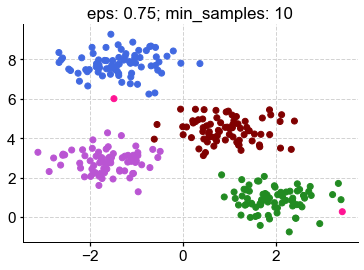

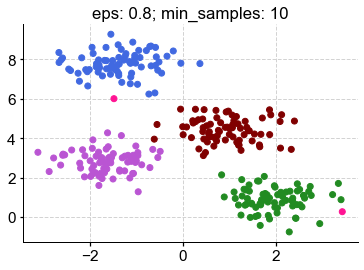

In [63]:
eps_list = [0.75,0.80]

for item in eps_list:
    m = DBSCAN(eps=item, min_samples=10)
    m.fit(X)
    colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'deeppink']
    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    plt.scatter(X[:,0], X[:,1], c=vectorizer(m.labels_))
    plt.title('eps: ' + str(item) + '; min_samples: 10')
    plt.show()

## Timeseries data: Knee Method

### "Perfect" Signal

In [18]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(signal_out.reshape(-1, 1))
distances, indices = nbrs.kneighbors(signal_out.reshape(-1, 1))

distances

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.22044605e-16],
       [0.00000000e+00, 2.22044605e-16],
       ...,
       [0.00000000e+00, 2.44249065e-15],
       [0.00000000e+00, 4.44089210e-16],
       [0.00000000e+00, 0.00000000e+00]])

(0.0, 0.03)

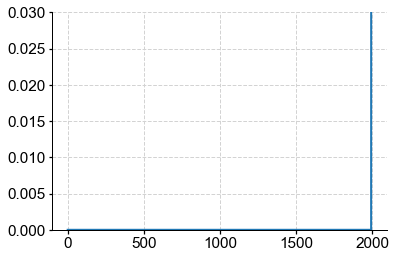

In [19]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.ylim([0,0.03])

Let's use eps = 0.01 for this example.

In [20]:
m = DBSCAN(eps=0.01, min_samples=2) 
model=m.fit(signal_out.reshape(-1,1))

In [21]:
np.unique(model.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35])

In [69]:
m.n_features_in_

1

In [71]:
len(m.core_sample_indices_)

1995

The documentation states that the noisy samples will be given a label of -1: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [72]:
np.where(m.labels_==-1)# detects the indices of outliers

(array([ 992, 1354, 1455, 1610, 1631, 1752]),)

### Effect of min_samples

There is not automatic way to determing the minimum number according to: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

In [74]:
m = DBSCAN(eps=0.01, min_samples=2) 
m.fit(signal_out.reshape(-1,1))
np.where(m.labels_==-1)# detects the indices of outliers

(array([ 992, 1354, 1455, 1610, 1631, 1752]),)

In [75]:
m = DBSCAN(eps=0.01, min_samples=3) 
m.fit(signal_out.reshape(-1,1))
np.where(m.labels_==-1)# detects the indices of outliers

(array([ 992, 1354, 1455, 1610, 1631, 1752]),)

In [76]:
m = DBSCAN(eps=0.01, min_samples=4) 
m.fit(signal_out.reshape(-1,1))
np.where(m.labels_==-1)# detects the indices of outliers

(array([ 992, 1354, 1455, 1610, 1631, 1752]),)

In [77]:
m = DBSCAN(eps=0.01, min_samples=6) #use the number of outliers to put in
m.fit(signal_out.reshape(-1,1))
np.where(m.labels_==-1)# detects the indices of outliers

(array([ 992, 1354, 1455, 1610, 1631, 1752]),)

In [78]:
m = DBSCAN(eps=0.01, min_samples=50) 
m.fit(signal_out.reshape(-1,1))
np.where(m.labels_==-1)# detects the indices of outliers

(array([   0,    6,   15,   32,   48,   65,   74,   80,   86,   95,  112,
         128,  145,  154,  160,  166,  175,  192,  208,  225,  234,  240,
         246,  255,  272,  288,  305,  314,  320,  326,  335,  352,  368,
         385,  394,  400,  406,  415,  432,  448,  465,  474,  480,  486,
         495,  512,  528,  545,  554,  560,  566,  575,  592,  608,  625,
         634,  640,  646,  655,  672,  688,  705,  714,  720,  726,  735,
         752,  768,  785,  794,  800,  806,  815,  832,  848,  865,  874,
         880,  886,  895,  912,  928,  945,  954,  960,  966,  975,  992,
        1008, 1025, 1034, 1040, 1046, 1055, 1072, 1088, 1105, 1114, 1120,
        1126, 1135, 1152, 1168, 1185, 1194, 1200, 1206, 1215, 1232, 1248,
        1265, 1274, 1280, 1286, 1295, 1312, 1328, 1345, 1354, 1360, 1366,
        1375, 1392, 1408, 1425, 1434, 1440, 1446, 1455, 1472, 1488, 1505,
        1514, 1520, 1526, 1535, 1552, 1568, 1585, 1594, 1600, 1606, 1610,
        1615, 1631, 1632, 1648, 1665, 

### Noisy dataset

Let's use colored noise to create a signal closer to paleoclimate data. 

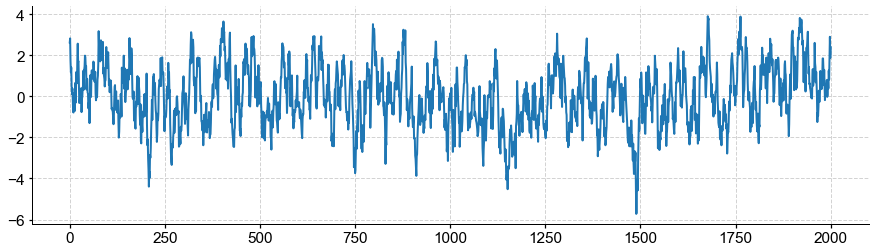

In [81]:
# Use a periodic signal as a base

freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

# Add colored noise

t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)

noisy_sig = signal + (v-np.mean(v))/np.std(v)

fig=plt.figure(figsize=(15,4))
plt.plot(time,noisy_sig)

Let's make sure we recover the periodicities:

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Period', ylabel='PSD'>)

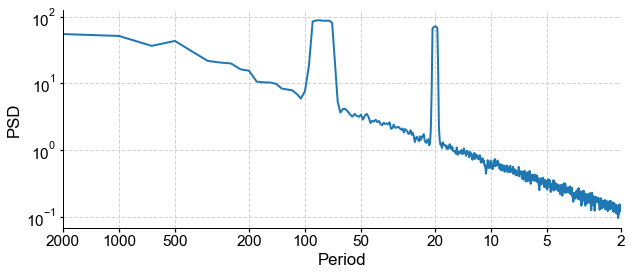

In [82]:
ts=pyleo.Series(time,noisy_sig)
ts.standardize().spectral(method='mtm').plot()

Let's add some outliers:

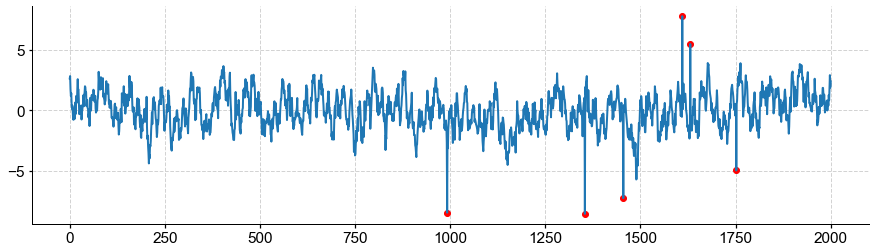

In [83]:
outliers_start = np.mean(noisy_sig)+3*np.std(noisy_sig)
outliers_end = np.mean(noisy_sig)+6*np.std(noisy_sig)
vals = np.arange(outliers_start,outliers_end,0.1)
outlier_values=np.concatenate((vals,-vals))

#set the outliers
nbr_out=6 #just add 6 random outliers
index = np.random.randint(0,len(noisy_sig),nbr_out) #Index on the time series
out_index = np.random.randint(0,len(outlier_values),nbr_out)
val_out=outlier_values[out_index]
time_out = time[index]

signal_out = np.copy(noisy_sig)
for idx,item in enumerate(index):
    signal_out[item] = val_out[idx]

fig=plt.figure(figsize=(15,4))
plt.plot(time,signal_out)
plt.scatter(time_out,outlier_values[out_index],color='r')

In [84]:
np.sort(index)

array([ 992, 1354, 1455, 1610, 1631, 1752])

In [93]:
def estimate_eps(ys):
    neigh = NearestNeighbors(n_neighbors=2)
    ys=(ys-np.mean(ys))/np.std(ys)
    nbrs = neigh.fit(ys.reshape(-1, 1))
    distances, indices = nbrs.kneighbors(ys.reshape(-1, 1))
    distances = sorted(distances[:,-1],reverse=True)
    x=np.arange(0,len(distances))
    kl = KneeLocator(x,distances,curve="convex", direction="decreasing", online=True)
    knee=kl.knee_y
    return knee  

def detect_outliers(ys,eps,min_samples,metric='euclidean'):
    m = DBSCAN(eps=eps, min_samples=min_samples,metric=metric) 
    m.fit(ys.reshape(-1,1))
    indices = np.where(m.labels_==-1)
    return indices

def plot_outliers(xs,ys,xs_out,ys_out,min_samples,metric):
    fig=plt.figure(figsize=(15,4))
    plt.plot(xs,ys,label='series')
    plt.scatter(xs_out,ys_out,color='r',label='outliers')
    plt.legend()
    plt.title('min_samples: '+str(min_samples)+', metric '+metric)
    plt.show()

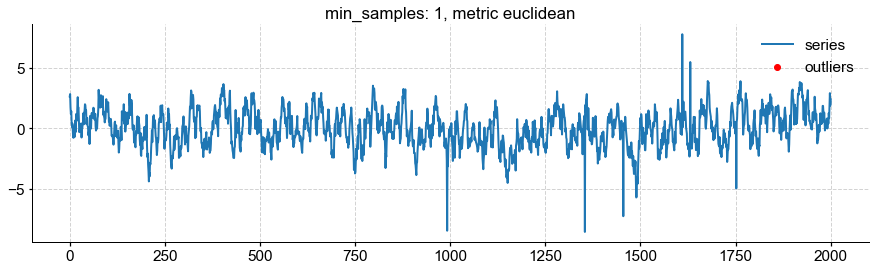

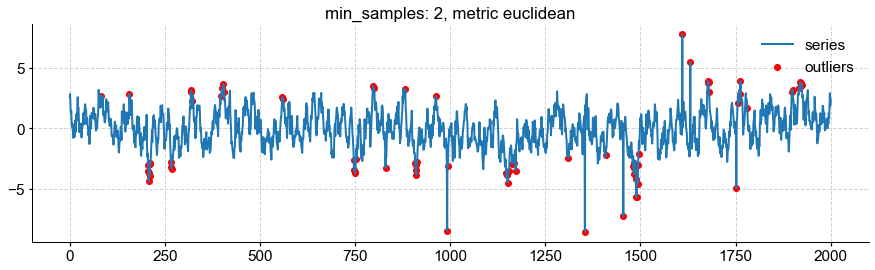

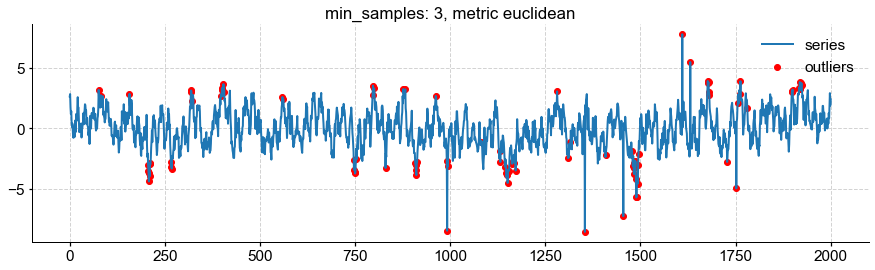

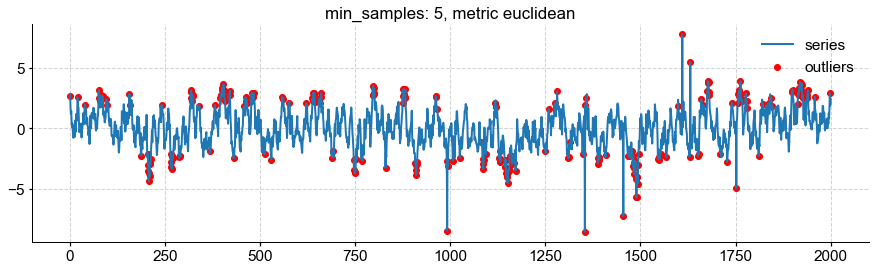

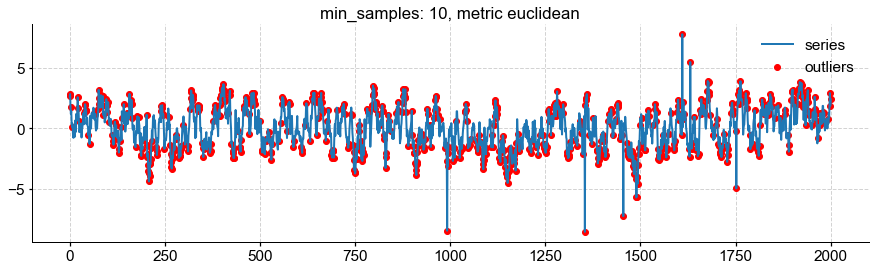

In [94]:
eps=estimate_eps(signal_out)
ms = [1,2,3,5,10]

p_idx=[]
for item in ms:
    indices=detect_outliers(signal_out,eps=eps,min_samples=item)
    xs_out=time[indices]
    ys_out=signal_out[indices]
    p_idx.append(indices)
    plot_outliers(time,signal_out,xs_out,ys_out,item,metric='euclidean')

With min_samples = 2, run through different metrics

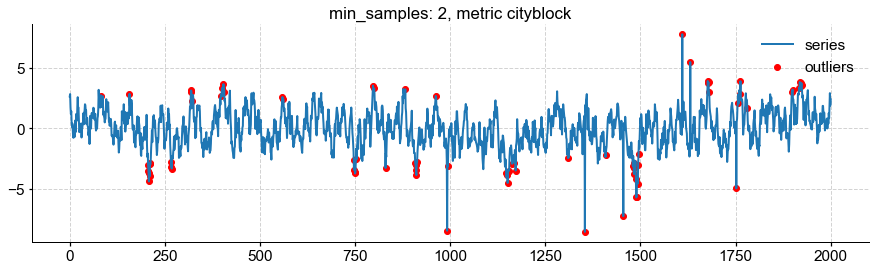

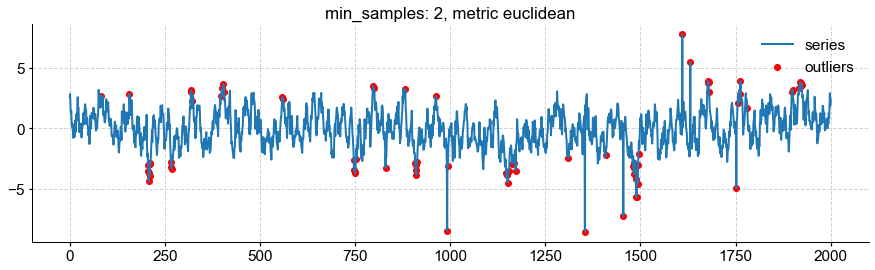

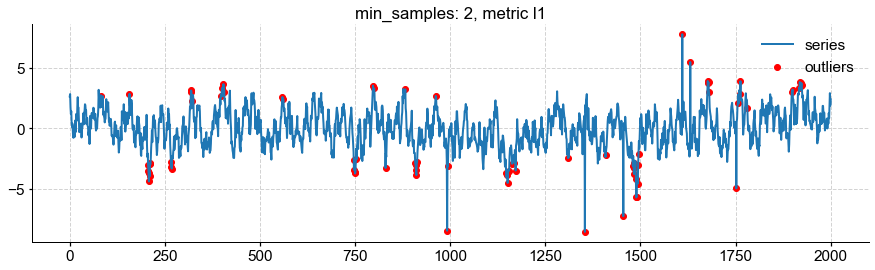

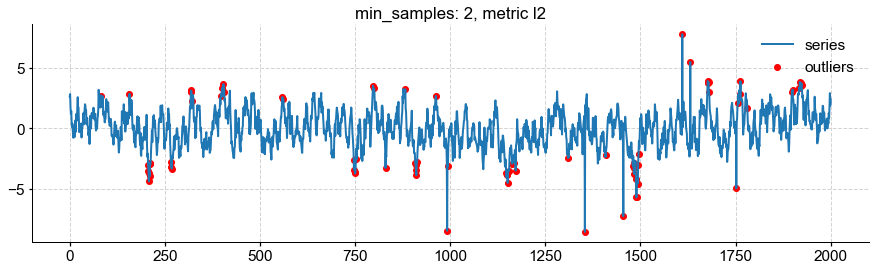

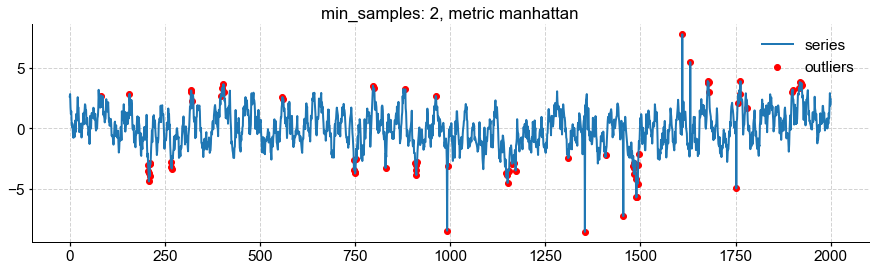

In [95]:
metrics=['cityblock', 'euclidean', 'l1', 'l2', 'manhattan']

for item in metrics:
    indices=detect_outliers(signal_out,eps=eps,min_samples=2,metric=item)
    xs_out=time[indices]
    ys_out=signal_out[indices]
    plot_outliers(time,signal_out,xs_out,ys_out,2,metric=item)

### Noisy Series without outliers

Let's look at the algorithm for the same series as above without outliers. 

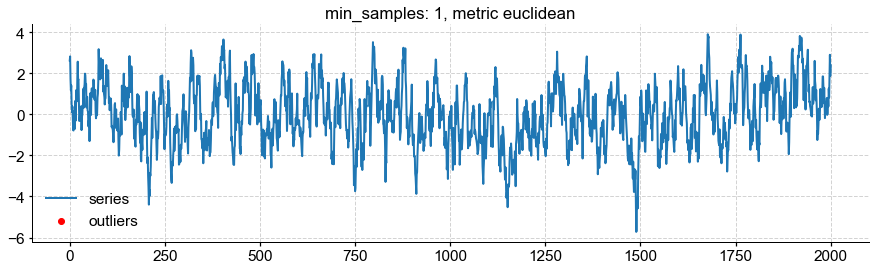

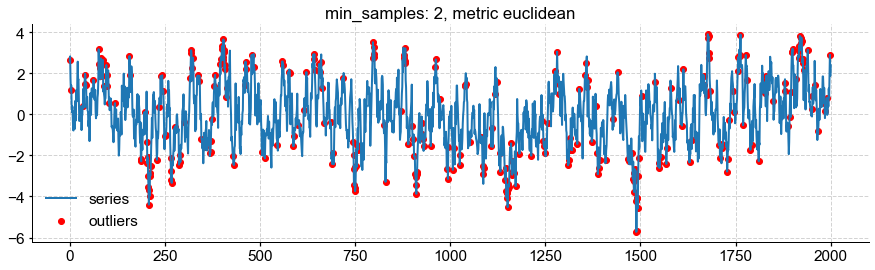

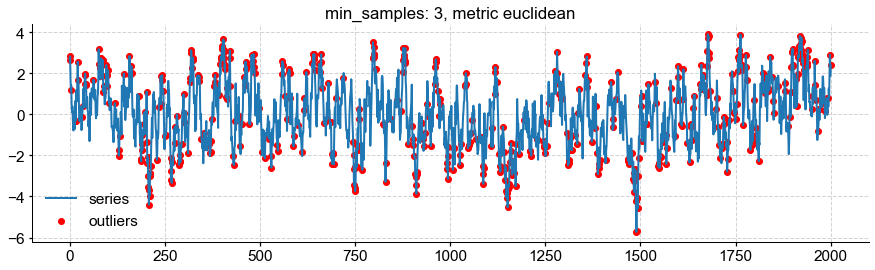

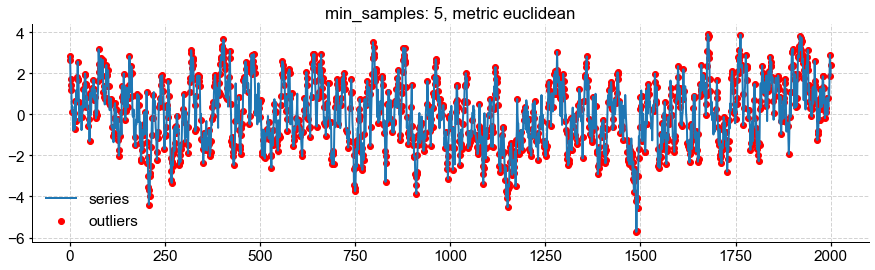

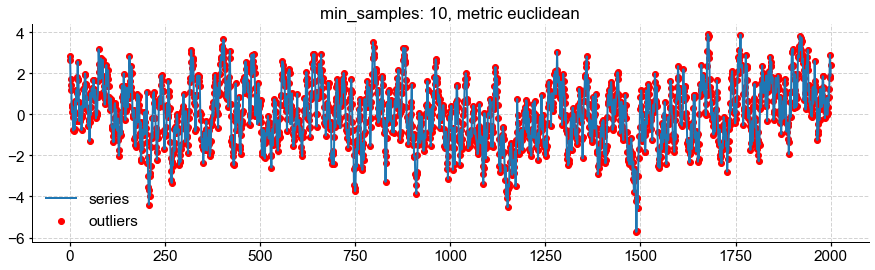

In [97]:
eps=estimate_eps(noisy_sig)
ms = [1,2,3,5,10]

p_idx=[]
for item in ms:
    indices=detect_outliers(noisy_sig,eps=eps,min_samples=item)
    xs_out=time[indices]
    ys_out=noisy_sig[indices]
    p_idx.append(indices)
    plot_outliers(time,noisy_sig,xs_out,ys_out,item,metric='euclidean')

## Timeseries Data: Silhouette Method

This is taken from: https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31

### Noisy dataset

Let's use a noisy signal with outliers for this test:

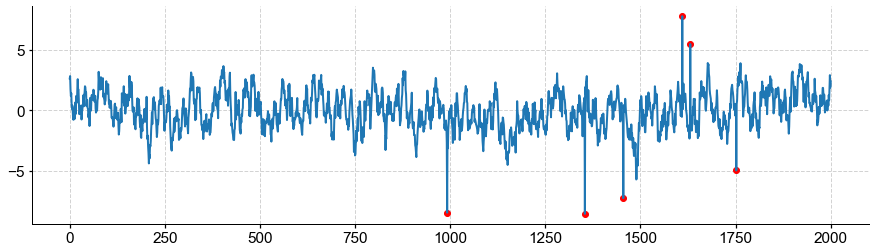

In [67]:
# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

# Add colored noise

t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)

noisy_sig = signal + (v-np.mean(v))/np.std(v)

outliers_start = np.mean(noisy_sig)+3*np.std(noisy_sig)
outliers_end = np.mean(noisy_sig)+6*np.std(noisy_sig)
vals = np.arange(outliers_start,outliers_end,0.1)
outlier_values=np.concatenate((vals,-vals))

#set the outliers
nbr_out=6 #just add 6 random outliers
index = np.random.randint(0,len(noisy_sig),nbr_out) #Index on the time series
out_index = np.random.randint(0,len(outlier_values),nbr_out)
val_out=outlier_values[out_index]
time_out = time[index]

signal_out = np.copy(noisy_sig)
for idx,item in enumerate(index):
    signal_out[item] = val_out[idx]

fig=plt.figure(figsize=(15,4))
plt.plot(time,signal_out)
plt.scatter(time_out,outlier_values[out_index],color='r')

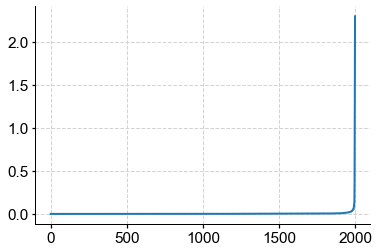

In [131]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(signal_out.reshape(-1, 1))
distances, indices = nbrs.kneighbors(signal_out.reshape(-1, 1))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [73]:
print(np.min(distances))
print(np.max(distances))

2.7665763446815816e-07
2.299999999999992


In [132]:
%%time
eps_list = np.linspace(np.min(distances),np.max(distances),22)
min_samples_list = np.linspace(2,len(signal_out)/2,22)

nbr_clusters=[]
sil_score =[]
eps_matrix=[]
min_sample_matrix=[]

for eps in eps_list:
    for min_samples in min_samples_list:
        eps_matrix.append(eps)
        min_sample_matrix.append(min_samples)
        m = DBSCAN(eps=eps, min_samples=min_samples)
        m.fit(signal_out.reshape(-1,1))
        nbr_clusters.append(len(np.unique(m.labels_)))
        try:
            sil_score.append(silhouette_score(signal_out.reshape(-1,1), m.labels_))
        except:
            sil_score.append(np.nan)
            
res = pd.DataFrame({'eps':eps_matrix,'min_samples':min_sample_matrix,'number of clusters':nbr_clusters,'silhouette score':sil_score})
res

CPU times: user 26.3 s, sys: 1.69 s, total: 28 s
Wall time: 28.1 s


,eps,min_samples,number of clusters,silhouette score
0,2.766576e-07,2.000000,2,-0.247253
1,2.766576e-07,49.547619,1,NaN
2,2.766576e-07,97.095238,1,NaN
3,2.766576e-07,144.642857,1,NaN
4,2.766576e-07,192.190476,1,NaN
...,...,...,...,...
479,2.300000e+00,810.309524,2,0.749542
480,2.300000e+00,857.857143,2,0.749542
481,2.300000e+00,905.404762,2,0.749542
482,2.300000e+00,952.952381,2,0.749542


In [133]:
res.max()

eps                      2.300000
min_samples           1000.500000
number of clusters       6.000000
silhouette score         0.796321
dtype: float64

In [85]:
res.loc[res['silhouette score']==np.max(res['silhouette score'])]

,eps,min_samples,number of clusters,silhouette score
463,2.3,49.547619,2,0.796321


Plot it:

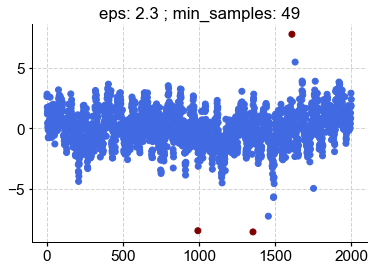

In [115]:
m = DBSCAN(eps=2.3, min_samples=49.547619)
m.fit(signal_out.reshape(-1,1))
colors = ['royalblue', 'maroon']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.scatter(time, signal_out, c=vectorizer(m.labels_))
plt.title('eps: 2.3 ; min_samples: 49')
plt.show()

In [117]:
cl_res= res.loc[res['number of clusters']==3]
cl_res

,eps,min_samples,number of clusters,silhouette score
266,0.082708,97.095238,3,-0.309296
354,0.110277,97.095238,3,-0.009240
421,0.130954,144.642857,3,-0.177207
443,0.137846,144.642857,3,-0.113522
465,0.144738,144.642857,3,0.007810


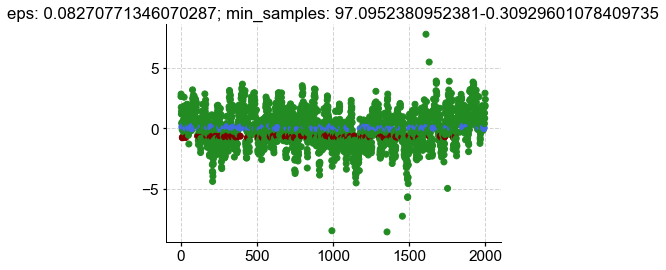

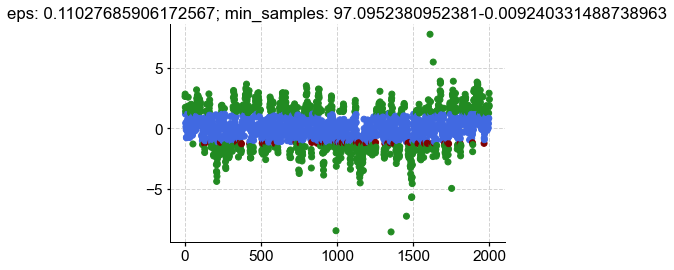

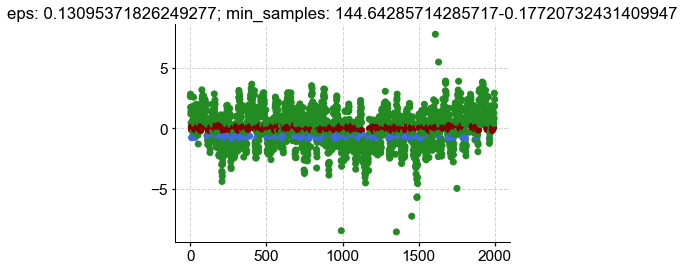

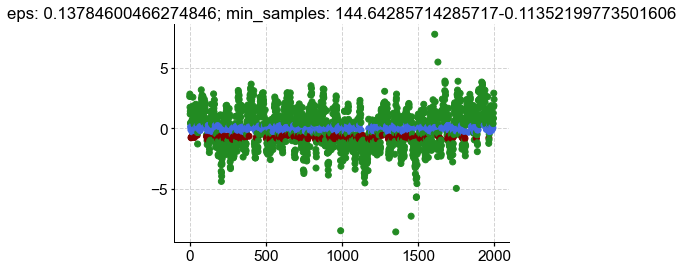

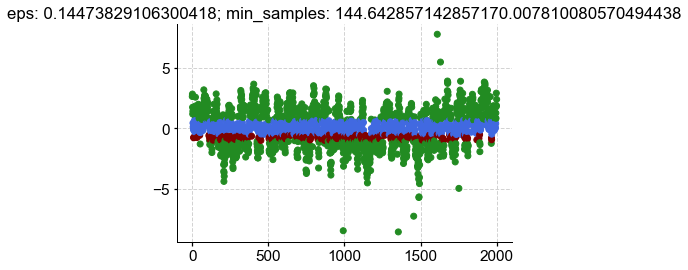

In [118]:
for index, row in cl_res.iterrows(): 
    m = DBSCAN(eps=row['eps'], min_samples=row['min_samples'])
    m.fit(signal_out.reshape(-1,1))
    colors = ['royalblue', 'maroon', 'forestgreen']
    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    plt.scatter(time, signal_out, c=vectorizer(m.labels_))
    plt.title('eps: ' + str(row['eps']) + '; min_samples: ' + str(row['min_samples']) + str(row['silhouette score']))
    plt.show()

### Noisy dataset without outliers

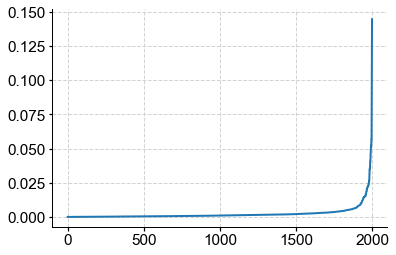

In [106]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(noisy_sig.reshape(-1, 1))
distances, indices = nbrs.kneighbors(noisy_sig.reshape(-1, 1))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [123]:
%%time
eps_list = np.linspace(np.min(distances),np.max(distances),22)
min_samples_list = np.linspace(2,len(noisy_sig)/2,22)

nbr_clusters=[]
sil_score =[]
eps_matrix=[]
min_sample_matrix=[]

for eps in eps_list:
    for min_samples in min_samples_list:
        eps_matrix.append(eps)
        min_sample_matrix.append(min_samples)
        m = DBSCAN(eps=eps, min_samples=min_samples)
        m.fit(noisy_sig.reshape(-1,1))
        nbr_clusters.append(len(np.unique(m.labels_)))
        try:
            sil_score.append(silhouette_score(signal_out.reshape(-1,1), m.labels_))
        except:
            sil_score.append(np.nan)
            
res = pd.DataFrame({'eps':eps_matrix,'min_samples':min_sample_matrix,'number of clusters':nbr_clusters,'silhouette score':sil_score})
res

CPU times: user 5.45 s, sys: 140 ms, total: 5.59 s
Wall time: 5.6 s


,eps,min_samples,number of clusters,silhouette score
0,2.766576e-07,2.000000,2,-0.247253
1,2.766576e-07,49.547619,1,NaN
2,2.766576e-07,97.095238,1,NaN
3,2.766576e-07,144.642857,1,NaN
4,2.766576e-07,192.190476,1,NaN
...,...,...,...,...
479,1.447383e-01,810.309524,1,NaN
480,1.447383e-01,857.857143,1,NaN
481,1.447383e-01,905.404762,1,NaN
482,1.447383e-01,952.952381,1,NaN


In [124]:
res.max()

eps                      0.144738
min_samples           1000.500000
number of clusters     160.000000
silhouette score         0.580232
dtype: float64

In [125]:
res.loc[res['silhouette score']==np.max(res['silhouette score'])]

,eps,min_samples,number of clusters,silhouette score
462,0.144738,2.0,3,0.580232


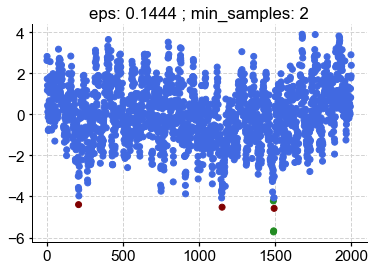

In [127]:
m = DBSCAN(eps=0.144738, min_samples=2)
m.fit(noisy_sig.reshape(-1,1))
colors = ['royalblue', 'maroon','forestgreen']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.scatter(time, noisy_sig, c=vectorizer(m.labels_))
plt.title('eps: 0.1444 ; min_samples: 2')
plt.show()

## Effect of nearest neighbors argument on distances

Note that distances are useful for both methods to either determine the knee or the range of eps value for optimization through silhouette score

In [139]:
n_list=np.arange(2,999,1)

max_dist=[]
min_dist=[]

for n in n_list:

    neigh = NearestNeighbors(n_neighbors=n)
    nbrs = neigh.fit(signal_out.reshape(-1, 1))
    distances, indices = nbrs.kneighbors(signal_out.reshape(-1, 1))
    max_dist.append(np.max(distances))
    min_dist.append(np.min(distances))

distance_res = pd.DataFrame({'number of neighbors':n_list, 'max distance':max_dist, 'min_distance':min_dist})

In [140]:
distance_res

,number of neighbors,max distance,min_distance
0,2,2.300000,0.0
1,3,3.869170,0.0
2,4,3.884153,0.0
3,5,3.952009,0.0
4,6,3.972745,0.0
...,...,...,...
992,994,8.554502,0.0
993,995,8.557178,0.0
994,996,8.560442,0.0
995,997,8.560906,0.0


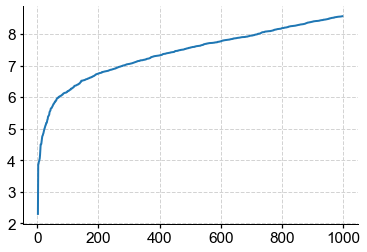

In [141]:
plt.plot(distance_res['number of neighbors'],distance_res['max distance'])

## Automated outlier detection using DBSCAN and optimization through silhouette score

In [52]:
def calculate_distances(ys, n_neighbors=None):
    
    ys=pyleo.utils.tsutils.standardize(ys)[0]
    ys=np.array(ys)
    
    if n_neighbors is None:
        # Lowest number of nearest neighbors
        neigh = NearestNeighbors(n_neighbors=2)
        nbrs = neigh.fit(ys.reshape(-1, 1))
        distances, indices = nbrs.kneighbors(ys.reshape(-1, 1))
        min_eps = np.min(distances)
        if min_eps<=0:
            min_eps=0.01
    
        # Highest number of nearest neighbors
        neigh = NearestNeighbors(n_neighbors=len(ys)-1)
        nbrs = neigh.fit(ys.reshape(-1, 1))
        distances, indices = nbrs.kneighbors(ys.reshape(-1, 1))
        max_eps = np.max(distances)
    
    else:
        neigh = NearestNeighbors(n_neighbors=n_neighbors)
        nbrs = neigh.fit(ys.reshape(-1, 1))
        distances, indices = nbrs.kneighbors(ys.reshape(-1, 1))
        min_eps = np.min(distances)
        max_eps = np.max(distances)
    
    return min_eps, max_eps

def detect_outliers_DBSCAN(ys, nbr_clusters = None, eps=None, min_samples=None, n_neighbors=None, metric='euclidean'):
    
    ys=pyleo.utils.tsutils.standardize(ys)[0] # standardization is key for the alogrithm to work.
    ys=np.array(ys)
    
    if eps is None:
        min_eps,max_eps = calculate_distances(ys, n_neighbors=n_neighbors)       
        eps_list = np.linspace(min_eps,max_eps,50)
    elif type(eps) is list:
        eps_list=eps
    else:
        print("You have tried to pass a float or integer, coercing to a list")
        eps_list=list(eps)
    
    if min_samples is None:
        min_samples_list = np.linspace(2,len(ys)/4,50,dtype='int')
    elif type(min_samples) is list:
        min_samples_list = min_samples
    else:
        print("You have tried to pass a float or integer, coercing to a list")
        min_samples_list=list(min_samples)
    
    print("Optimizing for the best number of clusters, this may take a few minutes")
    
    
    nbr_clusters=[]
    sil_score =[]
    eps_matrix=[]
    min_sample_matrix=[]
    idx_out = []
    clusters = []

    for eps_item in eps_list:
        for min_samples_item in min_samples_list:
            eps_matrix.append(eps_item)
            min_sample_matrix.append(min_samples_item)
            m = DBSCAN(eps=eps_item, min_samples=min_samples_item)
            m.fit(ys.reshape(-1,1))
            nbr_clusters.append(len(np.unique(m.labels_))-1)
            try:
                sil_score.append(silhouette_score(ys.reshape(-1,1), m.labels_))
            except:
                sil_score.append(np.nan)
            idx_out.append(np.where(m.labels_==-1)[0])
            clusters.append(m.labels_)
            
    res = pd.DataFrame({'eps':eps_matrix,'min_samples':min_sample_matrix,'number of clusters':nbr_clusters,'silhouette score':sil_score,'outlier indices':idx_out,'clusters':clusters})
    
    if nbr_clusters is None: 
        res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]
    else:
        res_cl = res.loc[res['number of clusters']==nbr_clusters]
        res_sil = res_cl.loc[res_cl['silhouette score']==np.max(res_cl['silhouette score'])]
    
    unique_idx = list(res_sil['outlier indices'].iloc[0])
    
    if res_sil.shape[0]>1:
        for idx,row in res_sil.iterrows():
            for item in row['outlier indices']:
                if item not in unique_idx:
                    unique_idx.append(item)
            
    indices = np.array(unique_idx)
    
    return indices, res



def plot_outliers(ts,ys,indices, figsize=[10,4]):
    fig,ax = plt.subplots(figsize=figsize)
    if np.size(indices) != 0:
        pyleo.utils.plotting.plot_scatter_xy(ts,ys,ts[indices],ys[indices],ax=ax)
    else:
        pyleo.utils.plotting.plot_xy(ts,ys,ax=ax)

def plot_clusters(ts, ys, clusters, indices, figsize=[10,4]):
    fig,ax = plt.subplots(figsize=figsize)
    color_list = list(mcolors.CSS4_COLORS.keys())
    color_list.remove('red')
    random.Random(9).shuffle(color_list)
    colors = color_list[0:len(np.unique(clusters))] 
    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    plt.scatter(ts, ys, c=vectorizer(clusters))
    if np.size(indices) != 0:
        plt.scatter(ts[indices],ys[indices],c='red')
    plt.show()

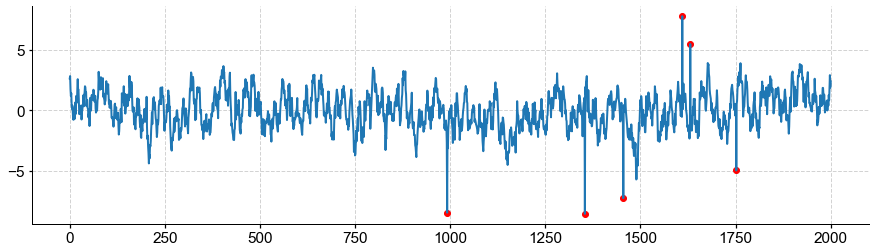

In [50]:
# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

# Add colored noise

t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)

noisy_sig = signal + (v-np.mean(v))/np.std(v)

outliers_start = np.mean(noisy_sig)+3*np.std(noisy_sig)
outliers_end = np.mean(noisy_sig)+6*np.std(noisy_sig)
vals = np.arange(outliers_start,outliers_end,0.1)
outlier_values=np.concatenate((vals,-vals))

#set the outliers
nbr_out=6 #just add 6 random outliers
index = np.random.randint(0,len(noisy_sig),nbr_out) #Index on the time series
out_index = np.random.randint(0,len(outlier_values),nbr_out)
val_out=outlier_values[out_index]
time_out = time[index]

signal_out = np.copy(noisy_sig)
for idx,item in enumerate(index):
    signal_out[item] = val_out[idx]

fig=plt.figure(figsize=(15,4))
plt.plot(time,signal_out)
plt.scatter(time_out,outlier_values[out_index],color='r')

In [53]:
%%time
indices, res = detect_outliers_DBSCAN(signal_out)

Optimizing for the best number of clusters, this may take a few minutes
CPU times: user 1min 27s, sys: 11.7 s, total: 1min 39s
Wall time: 1min 40s


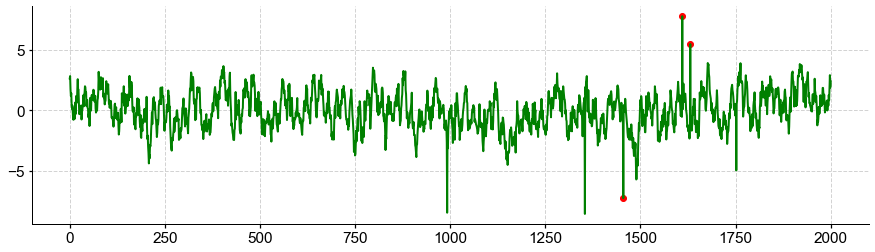

In [5]:
plot_outliers(time,signal_out,indices,figsize=(15,4))

In [54]:
res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]
res_sil

,eps,min_samples,number of clusters,silhouette score,outlier indices,clusters
301,1.328246,12,1,0.796321,"[992, 1354, 1610]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
353,1.547953,32,1,0.796321,"[992, 1354, 1610]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
354,1.547953,42,1,0.796321,"[992, 1354, 1610]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
355,1.547953,52,1,0.796321,"[992, 1354, 1610]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
406,1.767661,63,1,0.796321,"[992, 1354, 1610]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
595,2.426784,459,1,0.796321,"[992, 1354, 1610]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
596,2.426784,469,1,0.796321,"[992, 1354, 1610]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
597,2.426784,479,1,0.796321,"[992, 1354, 1610]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
598,2.426784,490,1,0.796321,"[992, 1354, 1610]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [55]:
np.unique(np.array(res_sil['number of clusters']))

array([1])

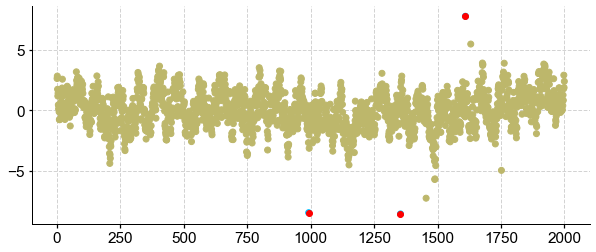

In [56]:
clusters = np.array(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['clusters'])[0]
plot_clusters(time, signal_out, clusters, indices, figsize=[10,4])

With no known outliers:

In [207]:
%%time
indices, res = detect_outliers_DBSCAN(noisy_sig)

Optimizing for the best number of clusters, this may take a few minutes
CPU times: user 1min 21s, sys: 11.6 s, total: 1min 32s
Wall time: 1min 33s


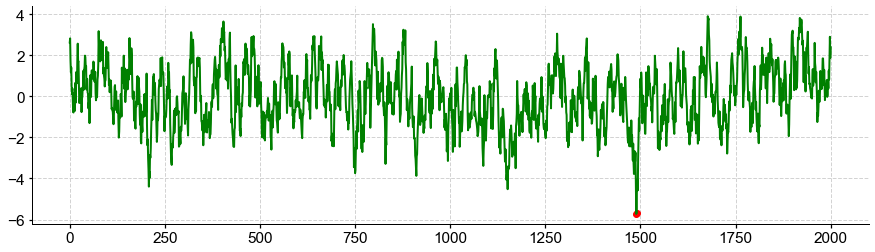

In [208]:
plot_outliers(time,noisy_sig,indices,figsize=(15,4))

## Working with real paleoclimate series:

We will consider three series:
- MD98-2181 SST over the Holocene from Khider et al. (low signal-to-noise ratio- outliers??)
- Deglacial Greenland d18O record, which contains a significant trend and the BA/YD event
- The LR04 record, which is not noisy but contains large climate shifts

### MD98-2181

In [57]:
D=pyleo.Lipd('MD982181.Khider.2014.lpd')

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: MD982181.Khider.2014.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Finished read: 1 record


In [58]:
ts=D.to_LipdSeries(number=14)

extracting paleoData...
extracting: MD982181.Khider.2014
Created time series: 31 entries


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [cal yr BP]', ylabel='sst [degrees Celcius]'>)

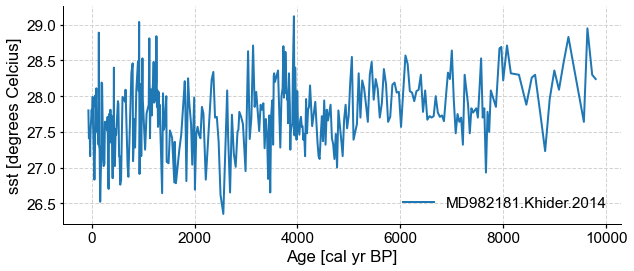

In [16]:
ts.plot()

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [cal yr BP]', ylabel='sst [degrees Celcius]'>)

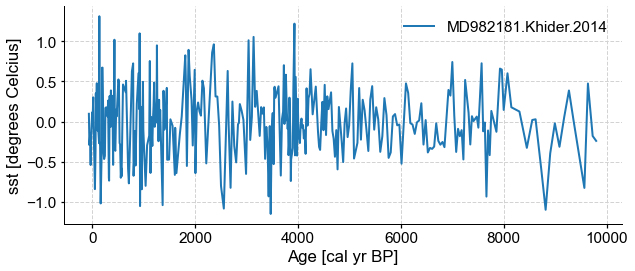

In [17]:
ts_detrended=ts.detrend(n=2)
ts_detrended.plot()

Optimizing for the best number of clusters, this may take a few minutes


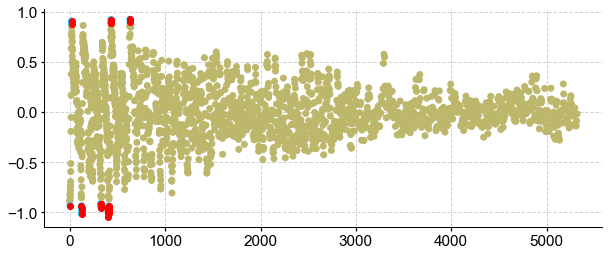

In [59]:
indices,res = detect_outliers_DBSCAN(ts_detrended.value)
clusters = np.array(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['clusters'])[0]
plot_clusters(ts_detrended.time, ts_detrended.value, clusters, indices, figsize=[10,4])

In [60]:
res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]
res_sil

,eps,min_samples,number of clusters,silhouette score,outlier indices,clusters
207,0.509735,77,1,0.626872,"[2, 18, 20, 122, 123, 125, 126, 324, 326, 327,...","[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [61]:
np.unique(np.array(res_sil['number of clusters']))

array([1])

### GISP2 d18O

In [62]:
df = pd.read_csv('GISP2_Deglacial.csv')
df

,Age [yr BP],d18O [per mil]
0,10014.2,-34.59
1,10038.0,-35.45
2,10061.5,-35.61
3,10084.5,-35.57
4,10109.4,-34.65
...,...,...
209,23303.0,-38.31
210,23406.0,-40.08
211,23528.0,-41.58
212,23656.0,-41.91


In [63]:
ts=pyleo.Series(time = df.iloc[:,0], value = df.iloc[:,1],
                time_name = 'Age', value_name='d18O',
                time_unit='yr BP', value_unit='per mil')

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [yr BP]', ylabel='d18O [per mil]'>)

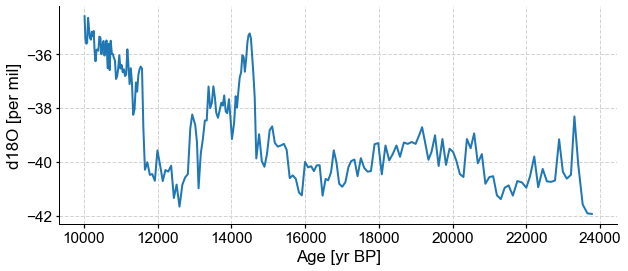

In [64]:
ts.plot()

Optimizing for the best number of clusters, this may take a few minutes


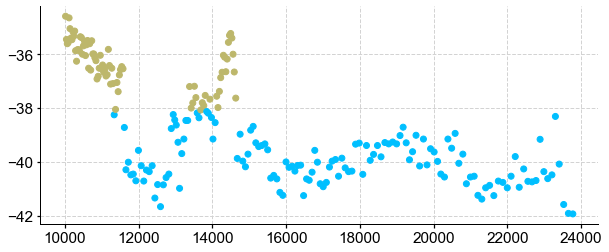

CPU times: user 3.41 s, sys: 46.3 ms, total: 3.46 s
Wall time: 3.32 s


In [65]:
%%time 
indices,res = detect_outliers_DBSCAN(ts.value)
clusters = np.array(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['clusters'])[0]
plot_clusters(ts.time, ts.value, clusters, indices, figsize=[10,4])

In [66]:
res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]
res_sil

,eps,min_samples,number of clusters,silhouette score,outlier indices,clusters
396,0.545422,50,1,0.68919,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
397,0.545422,51,1,0.68919,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
398,0.545422,52,1,0.68919,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


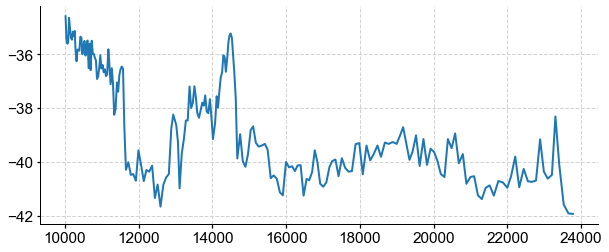

In [67]:
plot_outliers(ts.time, ts.value,indices)

### LR04

In [68]:
df = pd.read_csv('LR04.csv',skiprows=4)
df

,Time (ka),Benthic d18O (per mil),Standard error (per mil)
0,0.0,3.23,0.03
1,1.0,3.23,0.04
2,2.0,3.18,0.03
3,3.0,3.29,0.03
4,4.0,3.30,0.03
...,...,...,...
2110,5300.0,2.91,0.06
2111,5305.0,2.79,0.04
2112,5310.0,2.79,0.09
2113,5315.0,2.84,0.07


In [69]:
ts=pyleo.Series(time = df.iloc[:,0], value = df.iloc[:,1],
                time_name = 'Age', value_name='benthic d18O',
                time_unit='ks', value_unit='per mil')

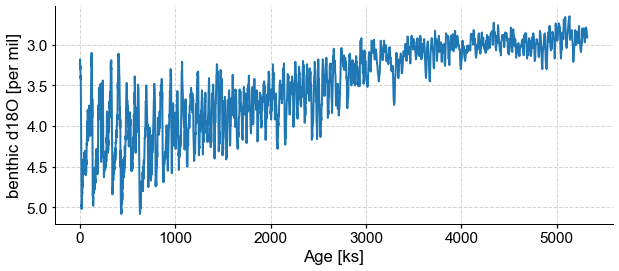

In [70]:
fig,ax = ts.plot()
ax.invert_yaxis()

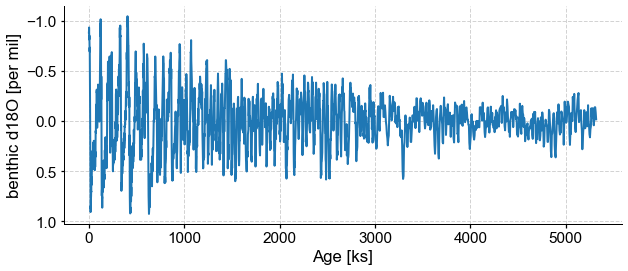

In [71]:
ts_detrended = ts.detrend()
fig,ax = ts_detrended.plot()
ax.invert_yaxis()

Optimizing for the best number of clusters, this may take a few minutes


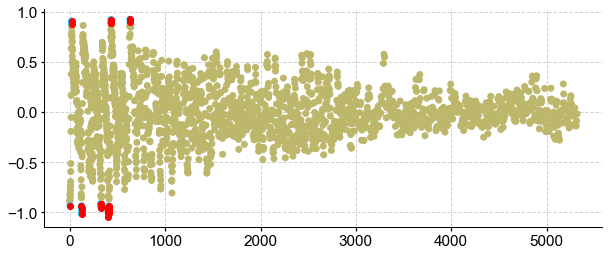

CPU times: user 1min 28s, sys: 14 s, total: 1min 43s
Wall time: 1min 43s


In [72]:
%%time 
indices,res = detect_outliers_DBSCAN(ts_detrended.value)
clusters = np.array(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['clusters'])[0]
plot_clusters(ts_detrended.time, ts_detrended.value, clusters, indices, figsize=[10,4])

In [73]:
res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]
res_sil

,eps,min_samples,number of clusters,silhouette score,outlier indices,clusters
207,0.509735,77,1,0.626872,"[2, 18, 20, 122, 123, 125, 126, 324, 326, 327,...","[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Using the clustering method to detect anomalies

In [74]:
D = pyleo.Lipd('Zhang.Hulu.2014.lpd')

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Zhang.Hulu.2014.lpd
Finished read: 1 record


In [75]:
ts=D.to_LipdSeries(number=2)

extracting paleoData...
extracting: Zhang.Hulu.2014
Created time series: 5 entries


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [year BP]', ylabel='D18O [permil VPDB]'>)

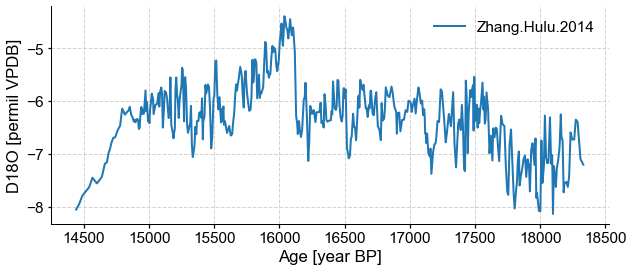

In [76]:
ts.plot()

Optimizing for the best number of clusters, this may take a few minutes


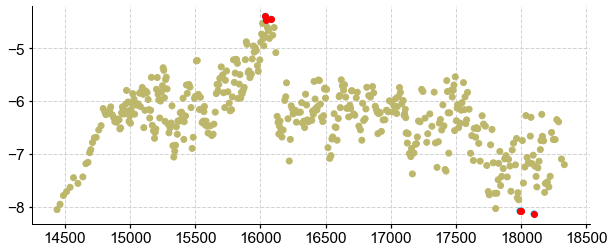

In [77]:
indices,res = detect_outliers_DBSCAN(ts.value)
clusters = np.array(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['clusters'])[0]
plot_clusters(ts.time, ts.value, clusters, indices, figsize=[10,4])

In [79]:
res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]
res_sil

,eps,min_samples,number of clusters,silhouette score,outlier indices,clusters
491,1.023015,95,1,0.604461,"[191, 192, 196, 417, 418, 430]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
492,1.023015,97,1,0.604461,"[191, 192, 196, 417, 418, 430]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
493,1.023015,99,1,0.604461,"[191, 192, 196, 417, 418, 430]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [80]:
event = D.to_LipdSeries(number=4)

extracting paleoData...
extracting: Zhang.Hulu.2014
Created time series: 5 entries


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [year BP]', ylabel='Event_0 [NA]'>)

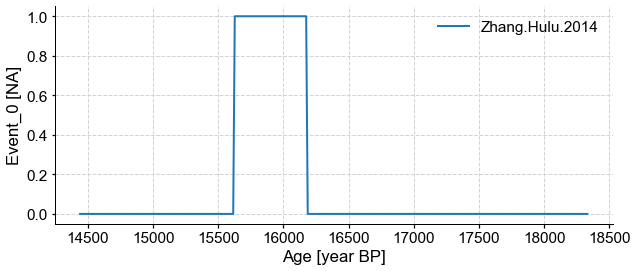

In [81]:
event.plot()